# Setting up `photoeccentric` sensitivitiy tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [3]:
muirhead_data = pd.read_csv("/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

# Kepler-Gaia Data
kpgaia = Table.read('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Read in MESA isochrones
isochrones = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


## Outline for Sensitivity Test

1. Define "test planet" parameters. These parameters will come from a real Kepler planet, but I'll use a fake light curve. These "test planet" parameters will stay the same across the entire test.
2. Write two functions: one that wraps the entire light curve initialization process, and one that wraps the transit fit and eccentricity estimation.
3. For each eccentricity recovered, take the difference between the input e and the peak of the e distribution as the error.
4. Plot on a heatmap

#### Defining a "test planet"

In [4]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

#iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

# Write to csv, then read back in (keeps python notebook from lagging)
#iso_lums.to_csv("feb19_21_iso_lums_" + str(kepid) + ".csv")

In [5]:
isodf = pd.read_csv(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/feb19_21_iso_lums_' + str(kepid) + '.csv')

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err)

In [6]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


In [7]:
def planetlc(time, per, rp, a, e, inc, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = e
    params.w = w                          #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [8]:
def photo_init(time, per, rp, a, e, inc, w):
    
    # Calculate flux from transit model
    flux = planetlc(time, period, rprs, a_rs, e, i, w)

    # Adding some gaussian noise
    noise = np.random.normal(0,0.000005,len(time))
    nflux = flux+noise
    
    flux_err = np.array([0.00005]*len(nflux))
    
    return nflux, flux_err

In [9]:
def chisqfunc(params, time, nflux, flux_err):
    per, rp, a, inc, w = params
    mod_flux = ph.planetlc_fitter(time, per, rp, a, inc, w)
    chisq = np.sum(((nflux - mod_flux)/flux_err)**2)
    return chisq

In [10]:
def log_likelihood(theta, time, flux, flux_err):
    """Log of likelihood
    model = ph.planetlc_fitter()
    gerr = sigma of g distribution
    """
    per, rp, a, inc, w = theta
    model = ph.planetlc_fitter(time, per, rp, a, inc, w)
    sigma2 = flux_err ** 2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    """Log of prior
    e between 0 and 1
    w between -90 and 300
    """
    per, rp, a, inc, w = theta
    if 0.0 < rp < 1.0 and 0.0 < inc < 100.0:
        return 0.0
    return -np.inf

def log_probability(theta, time, flux, flux_err):
    """Log of probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, flux_err)


In [11]:
def mcmc_fitter(p0, time, nflux, flux_err, nsteps, plot=False):
    
    solnx = (p0[0], p0[1], p0[2], p0[3], p0[4])
    pos = solnx + 1e-4 * np.random.randn(32, 5)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, nflux, flux_err), threads=4)
    sampler.run_mcmc(pos, nsteps, progress=True);
    samples = sampler.get_chain()
    
    if plot==True:
        fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
        labels = ["period", "rprs", "a/Rs", "i", "w"]
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
    pbins = np.arange(0.0, 10.0, 0.001)
    rbins = np.arange(0.0, 1.0, 0.0001)
    abins = np.arange(0.0, 100.0, 0.001)
    ibins = np.arange(0.0, 180.0, 0.01)
    wbins = np.arange(-90.0, 300.0, 0.01)
    
    pn = np.histogram(flat_samples[:,0], bins=pbins)[0]
    pm = np.argmax(pn)
    
    rn = np.histogram(flat_samples[:,1], bins=rbins)[0]
    rm = np.argmax(rn)
    
    an = np.histogram(flat_samples[:,2], bins=abins)[0]
    am = np.argmax(an)
    
    i_n = np.histogram(flat_samples[:,3], bins=ibins)[0]
    im = np.argmax(i_n)
    
    wn = np.histogram(flat_samples[:,4], bins=wbins)[0]
    wm = np.argmax(wn)
    
    return pbins[pm], rbins[rm], abins[am], ibins[im], wbins[wm]

In [12]:
time = np.linspace(-24, 24, 10000)

flux, flux_err = photo_init(time, period, rprs, a_rs, 0.0, i, 90.0)

p0 = np.array([4.8, 0.036066, 35.0945803495, 89.9, 0.0])

p, r, a, ie, w = mcmc_fitter(p0, time, flux, flux_err, 100)
#fsamp = mcmc_fitter(p0, time, flux, flux_err, 100)

100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


In [13]:
def photo_fit(time, nflux, flux_err, rho_star, plot=True, fitter="MCMC"):
    
    mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
    periodogram = mod.autopower(0.2, objective="snr")
    per_guess = np.asarray(periodogram.period)[int(np.median(np.argmax(periodogram.power)))]
    
    # Inital guess: period, rprs, a/Rs, i, w
    p0 = np.array([per_guess, 0.036066, 32.64384979582086, 89.9, 0.0])
    #p0 = np.array([per_guess, 0.036066, 45, 89.9, 0.0])

    
    if fitter=="MCMC":
        # EMCEE Transit Model Fitting
        p_f, rprs_f, a_f, i_f, w_f = mcmc_fitter(p0, time, nflux, flux_err, 1000, plot=False)
        
        perr_f = 0.001 #days to seconds
        rprserr_f = 0.001
    
    elif fitter!="MCMC":
        result =  opt.minimize(chisqfunc, p0, args=(time, nflux, flux_err), method=fitter)
    
        # Defining variables based on the fit parameters
        p_f = result.x[0] #days to seconds
        perr_f = 0.001 #days to seconds
        rprs_f = result.x[1]
        rprserr_f = 0.001
        a_f = result.x[2]
        i_f = result.x[3] 
        w_f = result.x[4]
        
    else:
        "You have to specify a fitting method"

    # Create a light curve with the fit parameters
    fit = ph.planetlc_fitter(time, p_f, rprs_f, a_f, i_f, w_f)
    
    if plot==True:
        plt.cla()
        plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
        plt.plot(time, fit, c='red', alpha=1.0, label='Fit LC')
        plt.xlim(-0.1, 0.1)
        plt.legend()
        plt.show()

        print('Fit params:')
        print('Period (days): ', p_f, 'Rp/Rs: ', rprs_f)
        print('a/Rs: ', a_f)
        print('i (deg): ', i_f)
        print('w (deg): ', w_f)
        
        
    T14 = ph.get_T14(p_f*86400, rprs_f, a_f, i_f)
    T14err = 0.0001*86400 #I'm assuming a T14 error here

    T23 = ph.get_T23(p_f*86400, rprs_f, a_f, i_f)
    T23err = 0.0001*86400 #I'm assuming a T23 error here

    gs, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rho_star, p_f*86400, perr_f*86400, rprs_f, rprserr_f, T14, T14err, T23, T23err)

    g_mean = np.mean(gs)
    g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))
    
    #Guesses
    w_guess = 0.0
    e_guess = 0.0

    solnx = (w_guess, e_guess)
    pos = solnx + 1e-4 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
    
    print('-------MCMC------')
    sampler.run_mcmc(pos, 5000, progress=True);
    flat_samples_e = sampler.get_chain(discard=100, thin=15, flat=True)
    
    
    ebins = np.arange(0.0, 1.0, 0.01)
    edist = flat_samples_e[:,1]
    
    n = np.histogram(flat_samples_e[:,1], bins=ebins)[0]
    elem = np.argmax(n)
    
    return ebins[elem]
    
    



# Using photo_init and photo_fit

In [22]:
time = np.linspace(-24, 24, 10000)

In [23]:
flux, flux_err = photo_init(time, period, rprs, a_rs, 0.1, i, 90.0)

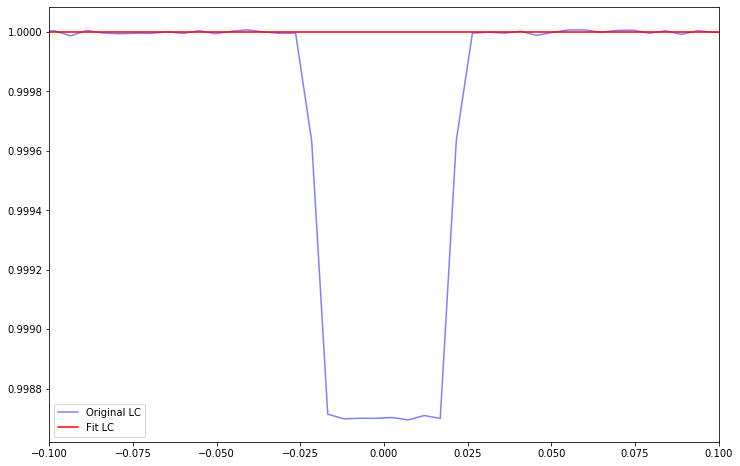

/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:44: RuntimeWarning: invalid value encountered in sqrt
  T14 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1+rprs)**2)-b**2))/np.sin(i*(np.pi/180.0))) #Equation 14 in exoplanet textbook
/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:86: RuntimeWarning: invalid value encountered in sqrt
  T23 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1-rprs)**2)-b**2))/np.sin(i*(np.pi/180.))) #Equation 15 in exoplanet textbook
100%|██████████| 1000/1000 [00:00<00:00, 97455.83it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  94.39500000000001
w (deg):  0.0


ValueError: supplied range of [nan, nan] is not finite

In [24]:
e_best_nm = photo_fit(time, flux, flux_err, rho_star, plot=True, fitter="Nelder-Mead")

100%|██████████| 1000/1000 [01:26<00:00, 11.59it/s]


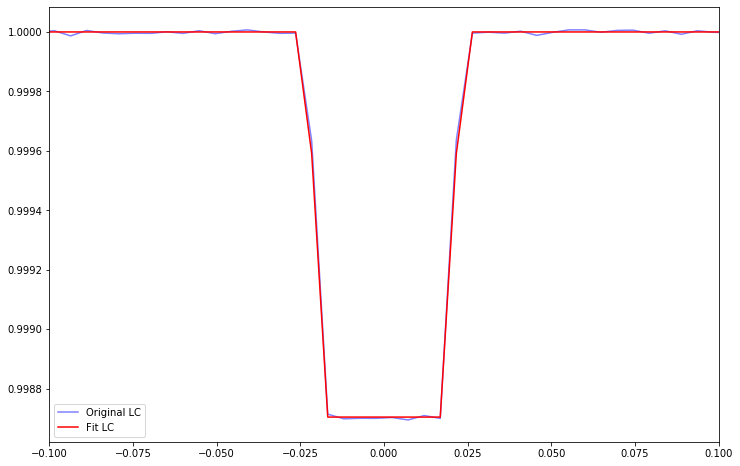

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 58/5000 [00:00<00:08, 573.67it/s]

Fit params:
Period (days):  4.838 Rp/Rs:  0.036000000000000004
a/Rs:  34.08
i (deg):  89.45
w (deg):  0.500000000046299
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 752.10it/s]


In [25]:
e_best_mcmc = photo_fit(time, flux, flux_err, rho_star, plot=True, fitter="MCMC")

In [28]:
e_best_mcmc

0.0

In [27]:
e_best_nm

0.01

## Possible es to test:

In [20]:
e_rand = np.random.uniform(0.0, 1.0, size=100)
w_rand = np.random.uniform(-90.0, 300.0, size=100)

Period (Days):  4.83809469
Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
e:  0.6898909082586693 w:  -6.042264775143607


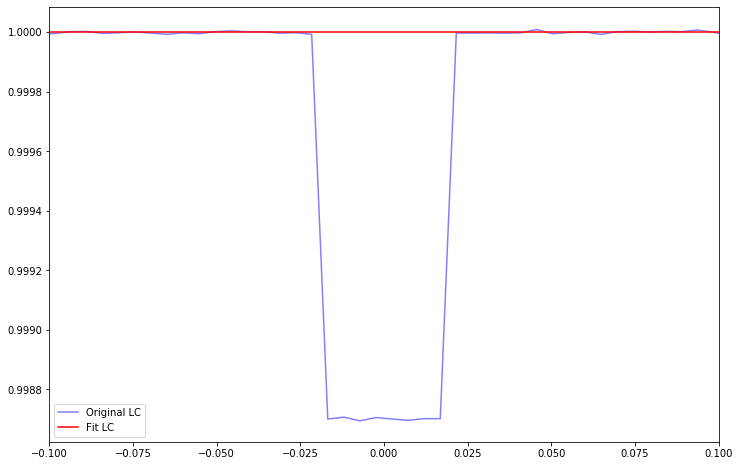

/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:44: RuntimeWarning: invalid value encountered in sqrt
  T14 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1+rprs)**2)-b**2))/np.sin(i*(np.pi/180.0))) #Equation 14 in exoplanet textbook
/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:86: RuntimeWarning: invalid value encountered in sqrt
  T23 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1-rprs)**2)-b**2))/np.sin(i*(np.pi/180.))) #Equation 15 in exoplanet textbook
100%|██████████| 1000/1000 [00:00<00:00, 46811.95it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  94.39500000000001
w (deg):  0.0
e:  0.9447972227721882 w:  -38.29210539905188


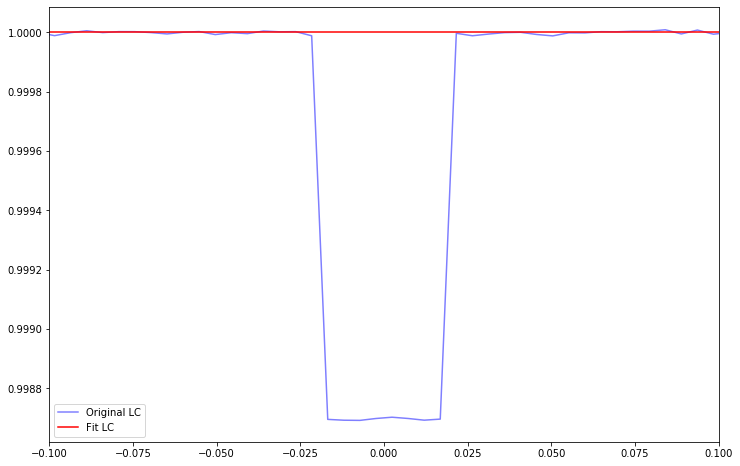

/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:44: RuntimeWarning: invalid value encountered in sqrt
  T14 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1+rprs)**2)-b**2))/np.sin(i*(np.pi/180.0))) #Equation 14 in exoplanet textbook
/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:86: RuntimeWarning: invalid value encountered in sqrt
  T23 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1-rprs)**2)-b**2))/np.sin(i*(np.pi/180.))) #Equation 15 in exoplanet textbook
100%|██████████| 1000/1000 [00:00<00:00, 85170.45it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  94.39500000000001
w (deg):  0.0
e:  0.5491501748556235 w:  49.134109161920435


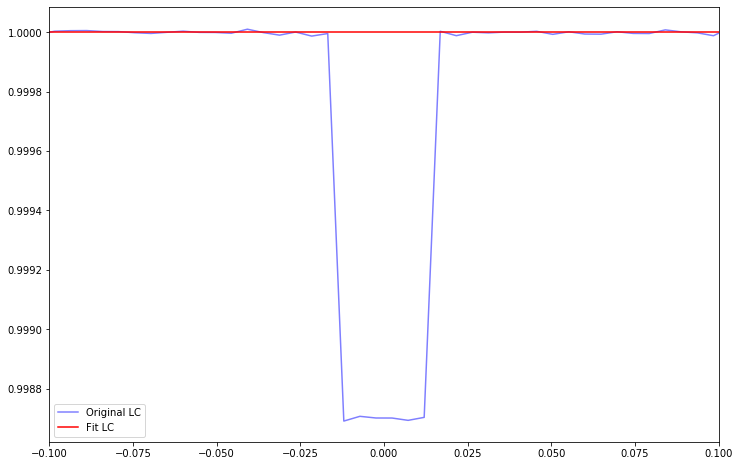

/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:44: RuntimeWarning: invalid value encountered in sqrt
  T14 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1+rprs)**2)-b**2))/np.sin(i*(np.pi/180.0))) #Equation 14 in exoplanet textbook
/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:86: RuntimeWarning: invalid value encountered in sqrt
  T23 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1-rprs)**2)-b**2))/np.sin(i*(np.pi/180.))) #Equation 15 in exoplanet textbook
100%|██████████| 1000/1000 [00:00<00:00, 92231.15it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  94.39500000000001
w (deg):  0.0
e:  0.13466829625289067 w:  -76.02154608993463


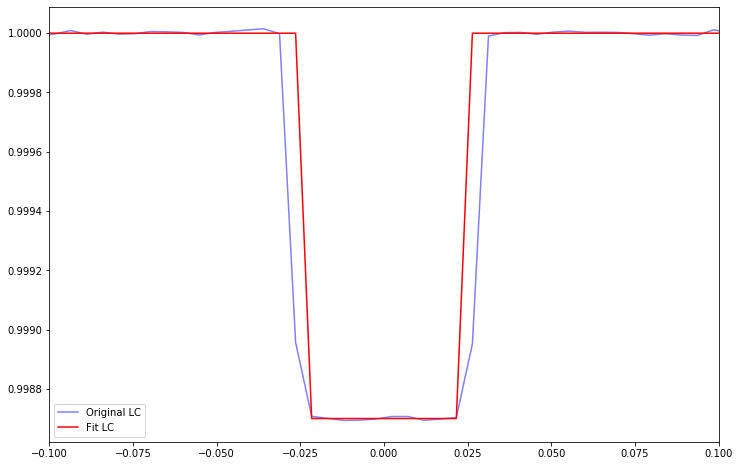

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 50/5000 [00:00<00:10, 493.31it/s]

Fit params:
Period (days):  4.838938466815723 Rp/Rs:  0.03606100069930359
a/Rs:  33.434972179678766
i (deg):  90.10232805423459
w (deg):  7.640960082306257e-05
-------MCMC------


 78%|███████▊  | 3891/5000 [00:06<00:01, 615.63it/s]


KeyboardInterrupt: 

In [21]:
es_best = []

print('Period (Days): ', period)
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

for j in range(40):
    print('e: ', e_rand[j], 'w: ', w_rand[j])
    ttime = np.linspace(-24, 24, 10000)
    tflux, tflux_err = photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j])
    try:
        es_best_c = photo_fit(ttime, tflux, tflux_err, rho_star, plot=True, fitter='Nelder-Mead')
        es_best.append(es_best_c)
    except ValueError:
        es_best.append(np.nan)
    

In [177]:
errs = np.abs((e_rand[0:40]-es_best)/e_rand[0:40])

In [178]:
errs

array([0.69886628, 0.12292111,        nan,        nan, 1.        ,
       0.92370463,        nan, 0.97984325, 1.        , 0.88709958,
       0.96220286, 0.04759074, 0.96943314,        nan, 0.1322745 ,
              nan, 1.        ,        nan, 0.28942343, 1.        ,
              nan, 0.27055036,        nan,        nan, 1.        ,
              nan,        nan, 0.98311933, 1.        , 0.56096077,
       0.01137244, 1.        , 0.96778503, 0.96493928, 1.        ,
       0.57088019, 0.98780424,        nan,        nan, 1.        ])

Text(0.5, 1.0, 'Color = Percent Error')

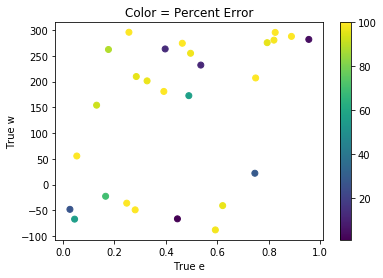

In [179]:
plt.scatter(e_rand[0:40], w_rand[0:40], c=errs*100)
plt.colorbar()
plt.xlabel('True e')
plt.ylabel('True w')
plt.title('Color = Percent Error')

Period (Days):  4.83809469
Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
e:  0.16603919494776487 w:  -22.624980451034602


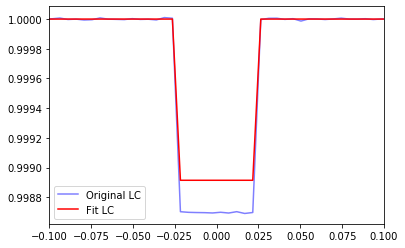

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 41/5000 [00:00<00:12, 409.59it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.032944360988082545
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:09<00:00, 533.85it/s]


e:  0.5358696995649722 w:  232.0567849709468


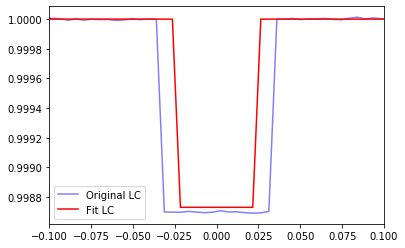

  0%|          | 0/5000 [00:00<?, ?it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.035619384860962416
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:13<00:00, 365.19it/s]


e:  0.757706646937518 w:  24.153788756763277


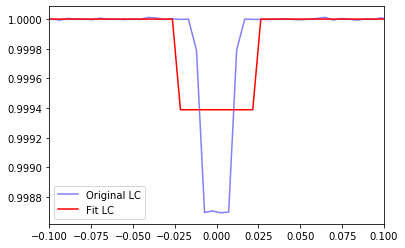

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 42/5000 [00:00<00:12, 399.94it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.02472612502099388
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:20<00:00, 248.59it/s]


e:  0.8956409529449341 w:  23.9221438941195


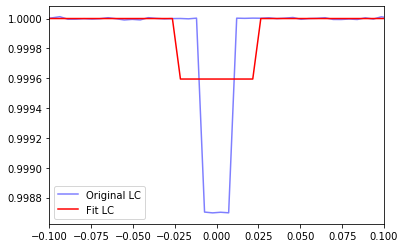

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 34/5000 [00:00<00:14, 337.32it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.020135208431525383
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:18<00:00, 275.96it/s]


e:  0.8248707508901231 w:  295.48912488296673


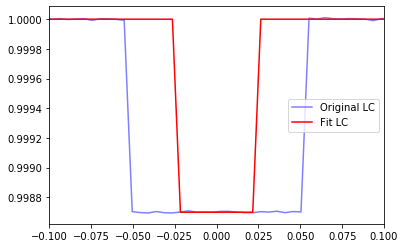

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 28/5000 [00:00<00:18, 276.09it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03606808209001954
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:17<00:00, 286.10it/s]


e:  0.13106955411486998 w:  154.19510102469647


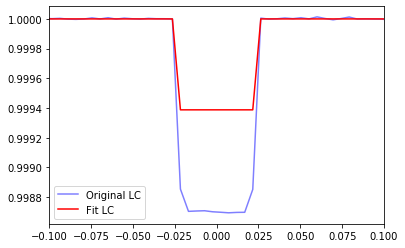

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 30/5000 [00:00<00:17, 286.79it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.024745419605885412
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:12<00:00, 401.64it/s]


e:  0.9563797652953506 w:  -43.008884723502774


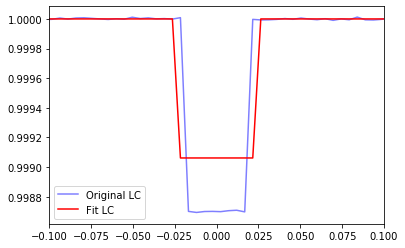

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 10/5000 [00:00<00:50, 98.25it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.0306358451948704
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:13<00:00, 365.22it/s]


e:  0.49611161177688634 w:  254.9738823699663


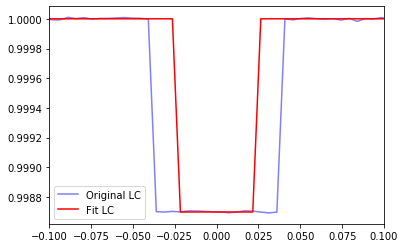

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 27/5000 [00:00<00:18, 269.77it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.0360593398708359
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:20<00:00, 245.26it/s]


e:  0.7489086698326708 w:  207.06122688599066


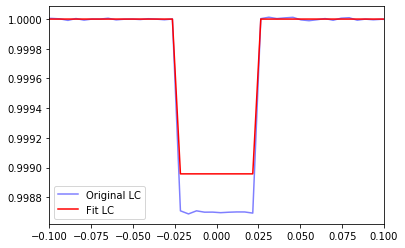

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 32/5000 [00:00<00:16, 306.60it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03228757687161278
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:17<00:00, 290.64it/s]


e:  0.1771472546244488 w:  262.3111866503576


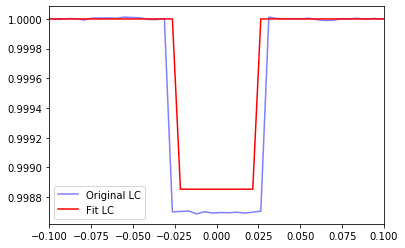

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 35/5000 [00:00<00:15, 327.66it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03386506885155221
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:17<00:00, 284.38it/s]


e:  0.7937107569613967 w:  275.57641798364665


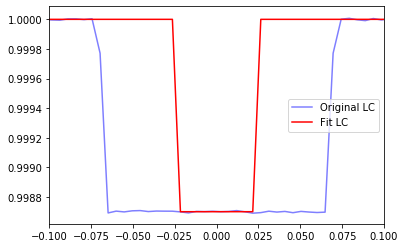

100%|██████████| 1000/1000 [00:00<00:00, 12597.74it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.036052895910723
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------



  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:18<00:00, 273.45it/s]


e:  0.9554716004551466 w:  281.89709256832964


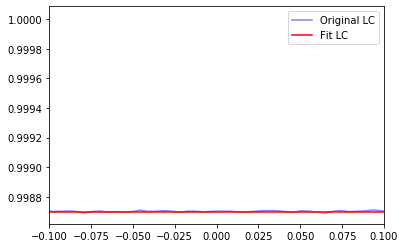

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 34/5000 [00:00<00:14, 337.33it/s]

Fit params:
Period (days):  4.838095409670081 Rp/Rs:  0.03606516964812369
a/Rs:  7.210722754701497
i (deg):  89.99302495693094
w (deg):  236.49420955321327
-------MCMC------


100%|██████████| 5000/5000 [00:17<00:00, 289.92it/s]


e:  0.3271516444041652 w:  201.39162626541594


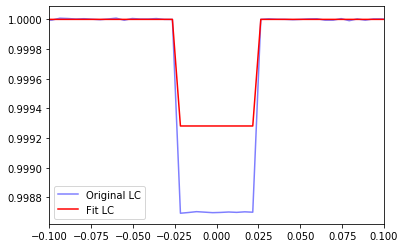

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 35/5000 [00:00<00:31, 158.06it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.02680372453982568
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:18<00:00, 270.83it/s]


e:  0.7758856274665192 w:  -0.8797659129578363


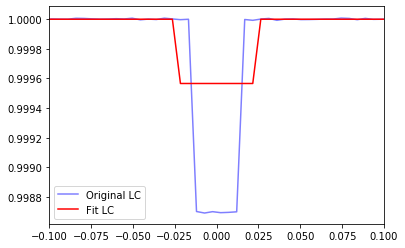

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 31/5000 [00:00<00:16, 308.69it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.020828627131935652
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:14<00:00, 354.16it/s]


e:  0.3974301287212866 w:  263.3759449225479


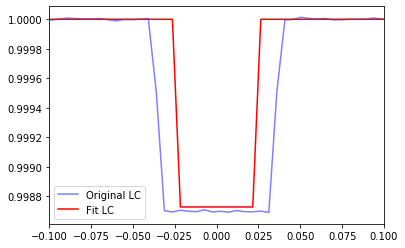

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 32/5000 [00:00<00:15, 314.18it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.035656076515545566
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:22<00:00, 219.88it/s]


e:  0.6656021178929414 w:  191.29202192192093


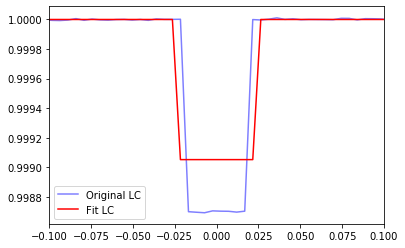

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 41/5000 [00:00<00:12, 402.57it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.030784179360397488
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:11<00:00, 420.99it/s]


e:  0.8880209013822323 w:  287.7608746929172


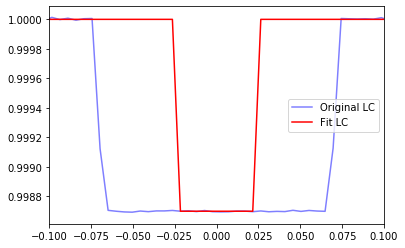

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 36/5000 [00:00<00:13, 358.51it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03606737587398237
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:09<00:00, 528.44it/s]


e:  0.6957953817150964 w:  41.4212453198584


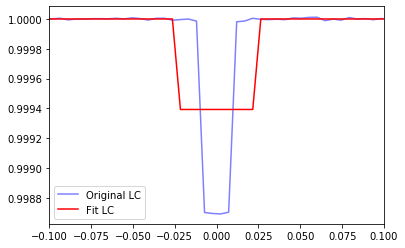

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 30/5000 [00:00<00:16, 293.97it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.02464845208921629
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:10<00:00, 494.34it/s]


e:  0.7458731718803626 w:  22.062084119463137


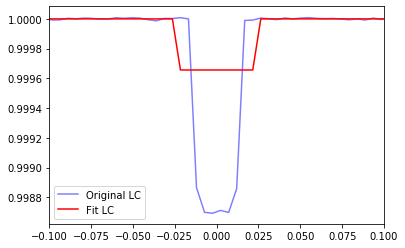

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 35/5000 [00:00<00:14, 348.57it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.01853658446623149
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:09<00:00, 506.57it/s]


e:  0.05409682434037166 w:  55.54546066622589


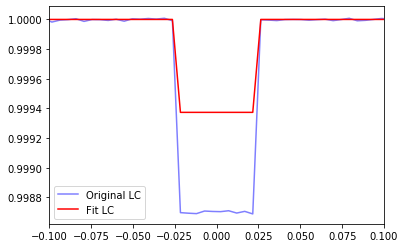

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 30/5000 [00:00<00:16, 299.62it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.02503666817860247
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:15<00:00, 329.65it/s]


e:  0.6199231165074983 w:  179.6153795137904


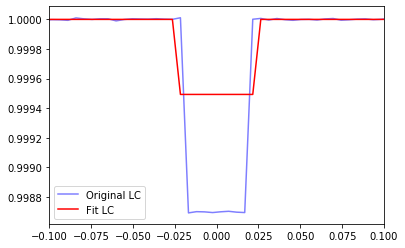

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 20/5000 [00:00<00:25, 195.35it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.022518045905793045
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:19<00:00, 262.19it/s]


e:  0.02741793110552071 w:  -48.00730915669212


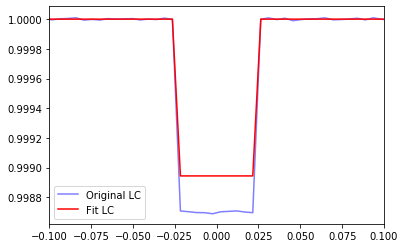

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 7/5000 [00:00<01:11, 69.64it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03249884372893793
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:18<00:00, 265.54it/s]


e:  0.6759180307656808 w:  160.9411674338989


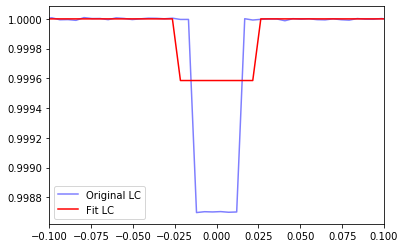

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 33/5000 [00:00<00:15, 326.20it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.02036234211762281
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:26<00:00, 185.24it/s]


e:  0.720063983280155 w:  9.638538875394843


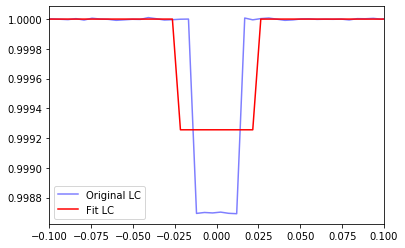

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 28/5000 [00:00<00:18, 275.59it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.027280088643712775
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:16<00:00, 303.84it/s]


e:  0.46400753824411445 w:  274.4097686626268


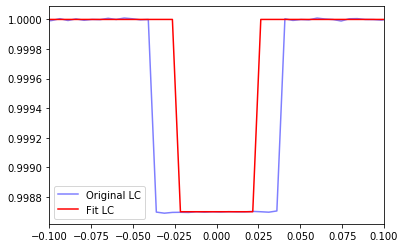

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 27/5000 [00:00<00:18, 266.97it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.036060680606972546
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:15<00:00, 329.04it/s]


e:  0.6538032609894537 w:  91.72629847651572


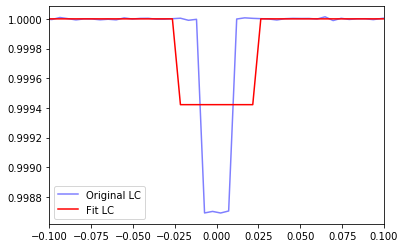

  0%|          | 0/5000 [00:00<?, ?it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.024047061032287455
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:23<00:00, 210.94it/s]


e:  0.3399613848397486 w:  105.07523866202467


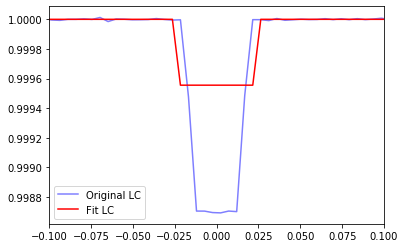

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 34/5000 [00:00<00:14, 336.50it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.02109704484152923
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:17<00:00, 285.02it/s]


e:  0.5923936677156553 w:  -87.93360064565206


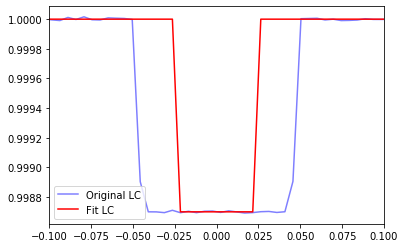

  0%|          | 0/5000 [00:00<?, ?it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03605520508057719
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:25<00:00, 199.36it/s]


e:  0.3922690552118313 w:  180.9004728885766


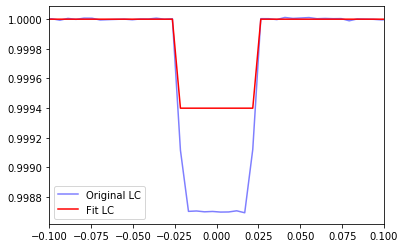

 31%|███       | 306/1000 [00:00<00:00, 3059.87it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.024511498408030262
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 21/5000 [00:00<00:24, 205.81it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:20<00:00, 243.53it/s]


e:  0.045554016177005274 w:  -67.02322115035986


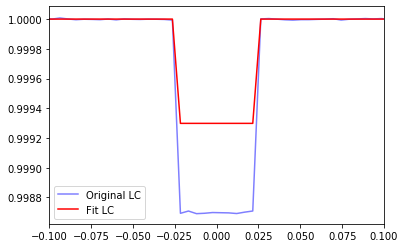

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 21/5000 [00:00<00:24, 204.78it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.026484530793527708
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:19<00:00, 259.62it/s]


e:  0.44506143658709607 w:  -66.43457486047114


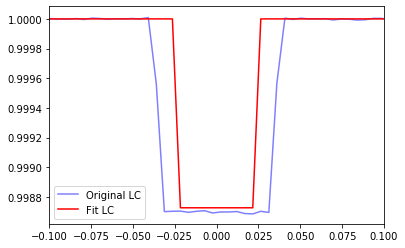

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 26/5000 [00:00<00:19, 256.88it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.035682785468912875
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:12<00:00, 388.31it/s]


e:  0.28081961209070394 w:  -48.988131345907824


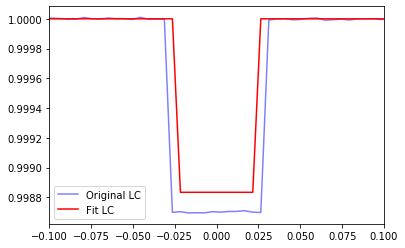

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 32/5000 [00:00<00:15, 319.59it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03414783126827536
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:16<00:00, 308.80it/s]


e:  0.6208292934840163 w:  -40.75136151582056


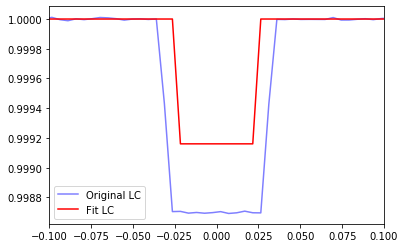

  0%|          | 0/5000 [00:00<?, ?it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.02897364333600614
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:27<00:00, 184.56it/s]


e:  0.2852194760912298 w:  209.82001288749973


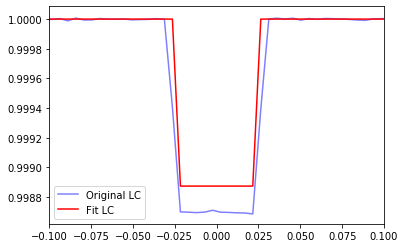

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 34/5000 [00:00<00:16, 306.46it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.033545974118982434
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:15<00:00, 327.87it/s]


e:  0.2566369426173817 w:  295.7850440240384


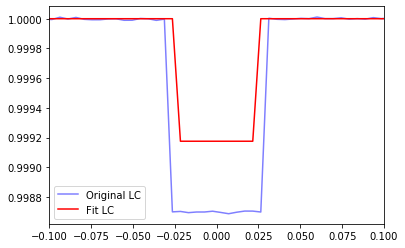

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 18/5000 [00:00<00:28, 174.56it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.02870569825676286
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:21<00:00, 238.05it/s]


e:  0.48937382346670166 w:  172.69834145914132


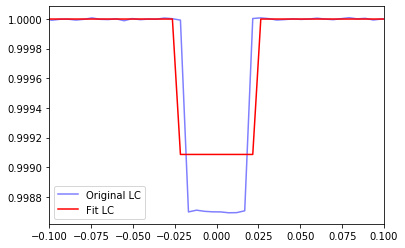

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 32/5000 [00:00<00:15, 317.05it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.030234899333093156
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:25<00:00, 195.81it/s]


e:  0.8199574205543961 w:  280.472506796149


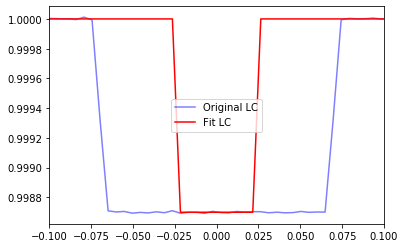

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 7/5000 [00:00<01:12, 69.23it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03605583055091864
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:17<00:00, 281.70it/s]


e:  0.9615918203618055 w:  126.08967949964764


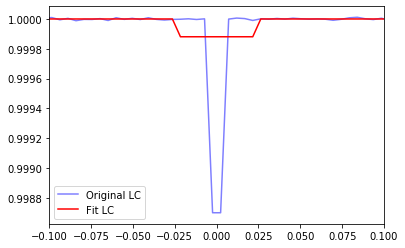

  0%|          | 0/5000 [00:00<?, ?it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.010929445123957477
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:14<00:00, 348.10it/s]


e:  0.8671940823849915 w:  27.424927820845483


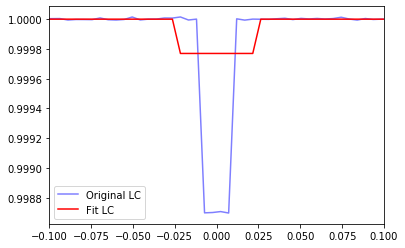

  0%|          | 0/5000 [00:00<?, ?it/s]

Fit params:
Period (days):  4.848484848484853 Rp/Rs:  0.015180001737506164
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:14<00:00, 354.18it/s]


e:  0.24809263118534786 w:  -36.000058595371364


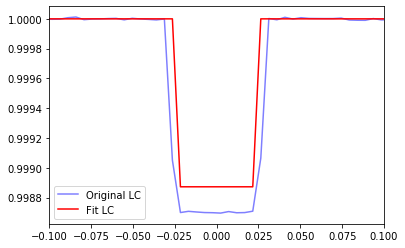

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 23/5000 [00:00<00:21, 228.33it/s]

Fit params:
Period (days):  4.8342425514057945 Rp/Rs:  0.03357677876036508
a/Rs:  32.64384979582086
i (deg):  89.9
w (deg):  0.0
-------MCMC------


100%|██████████| 5000/5000 [00:14<00:00, 344.22it/s]


In [182]:
es_best_2 = []

print('Period (Days): ', period)
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

for j in range(40):
    print('e: ', e_rand[j], 'w: ', w_rand[j])
    ttime = np.linspace(-24, 24, 10000)
    tflux, tflux_err = photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j])
    try:
        es_best_c = photo_fit(ttime, tflux, tflux_err, rho_star, plot=True, fitter='BFGS')
        es_best_2.append(es_best_c)
    except ValueError:
        es_best_2.append(np.nan)

In [185]:
errs_2 = np.abs((e_rand[0:40]-es_best)/e_rand[0:40])

Text(0.5, 1.0, 'Color = Percent Error')

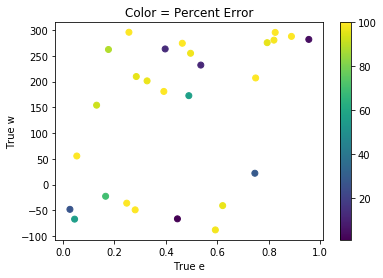

In [186]:
plt.scatter(e_rand[0:40], w_rand[0:40], c=errs_2*100)
plt.colorbar()
plt.xlabel('True e')
plt.ylabel('True w')
plt.title('Color = Percent Error')